# Introduction 

For this assignment, I have selected the **Wine dataset** as the foundation for a dimensionality reduction and classification task. The primary goal is to apply **Principal Component Analysis (PCA)** to effectively reduce the dimensionality of the dataset, while retaining as much variance as possible. This process simplifies the dataset, making it easier to visualize and potentially improving the efficiency and performance of classification algorithms. <br>
After applying PCA, the transformed dataset will be used to classify wine samples into one of several types based on the reduced features. The focus will be on using a logistic regression classifier for the final classification task, aiming to accurately predict the type of wine from its chemical properties.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns

## Dataset Overview

The dataset chosen for this assignment is the **Wine dataset**, which is aimed at evaluating the classification performance of machine learning models on a dimensionality-reduced dataset.

### Key Characteristics:

- **Number of Data Points**: The dataset contains 178 data points.

- **Number of Features**: It comprises 13 features, each representing different chemical properties of wines:
  - `Alcohol`: The alcohol content in the wine.
  - `Malic acid`: The amount of malic acid in the wine.
  - `Ash`: The ash content in the wine.
  - `Alcalinity of ash`: The alkalinity of the ash found in the wine.
  - `Magnesium`: The magnesium content in the wine.
  - `Total phenols`: The total amount of phenols in the wine.
  - `Flavanoids`: The flavanoid content in the wine.
  - `Nonflavanoid phenols`: The non-flavanoid phenol content in the wine.
  - `Proanthocyanins`: The proanthocyanin content in the wine.
  - `Color intensity`: The intensity of the wine's color.
  - `Hue`: The hue of the wine.
  - `OD280/OD315 of diluted wines`: The wine's absorbance ratio, indicating protein content.
  - `Proline`: The proline content in the wine.

- **Labels/Classes**: There are three classes in the dataset, corresponding to three different cultivars of wine. These classes are:
  - Class 0
  - Class 1
  - Class 2

Each class represents a different type of wine cultivar from the same region in Italy, providing a diverse dataset for classification tasks. The objective is to predict the wine cultivar using the chemical properties provided in the dataset features.



## Graphical Representation of the Data

We will visualize the relationships between the three wine cultivar classes and the thirteen features representing various chemical properties of wine. These features include Alcohol, Malic Acid, Ash, Alcalinity of Ash, Magnesium, Total Phenols, Flavanoids, Nonflavanoid Phenols, Proanthocyanins, Color Intensity, Hue, OD280/OD315 of Diluted Wines, and Proline. 

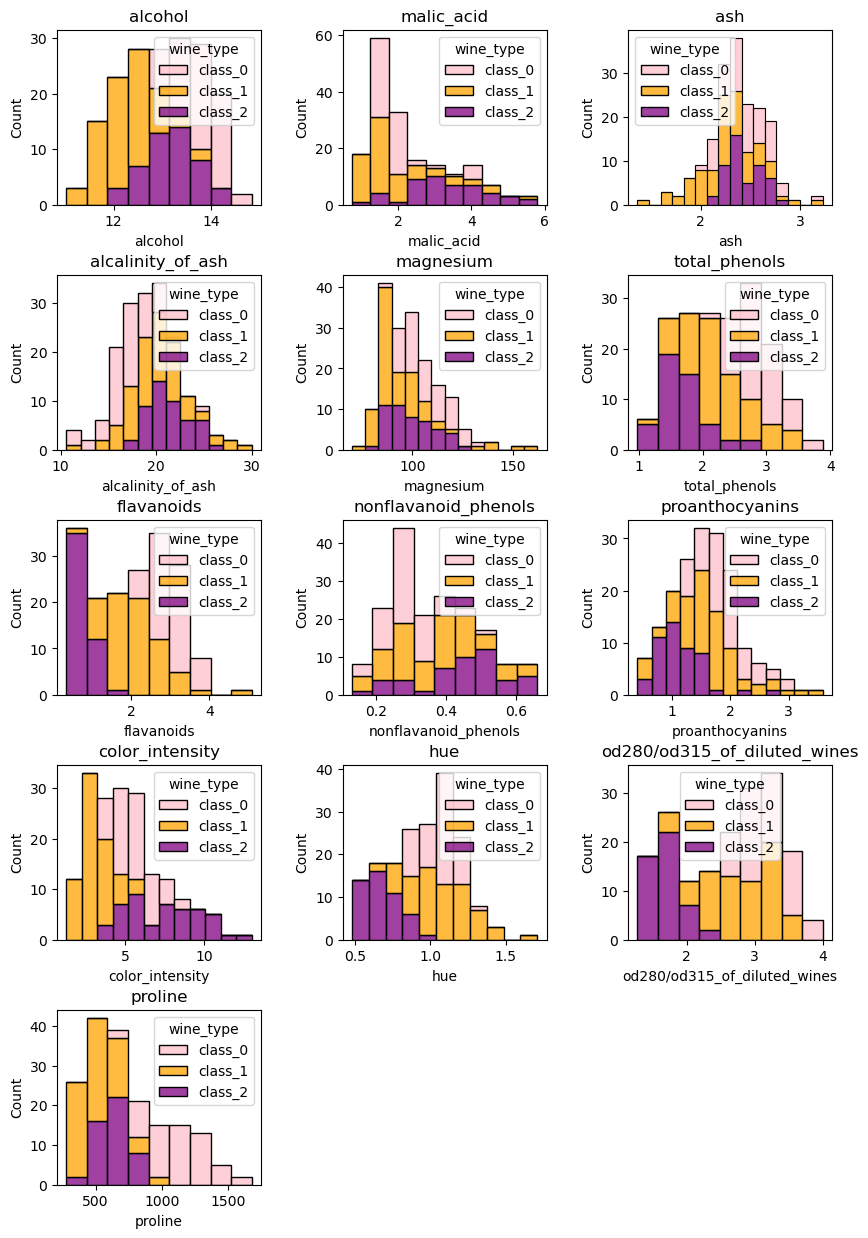

In [2]:
# Load the Wine dataset
wine = load_wine()

wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
# Assign wine type names directly to ensure compatibility
wine_df['wine_type'] = pd.Categorical.from_codes(wine.target, wine.target_names)

# Correctly define the color palette
# Map the palette to the actual wine type names or to the codes if names are not available
palette_colors = {wine.target_names[i]: color for i, color in enumerate(["pink", "orange", "purple"])}

# Set up the matplotlib figure
fig, axes = plt.subplots(5, 3, figsize=(10, 15)) # Adjusted for 13 features
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust spacing between plots

for i, ax in enumerate(axes.flatten()):
    if i < 13: # We have 13 features to plot
        sns.histplot(wine_df, x=wine.feature_names[i], hue="wine_type", multiple="stack", palette=palette_colors, ax=ax)
        ax.set_title(wine.feature_names[i])
    else:
        ax.set_visible(False) # Hide subplot if no feature to plot

plt.show()

# Custom PCA

**Eigenvalue and Eigenvector Sorting (eigsort Function):**

Computes the eigenvalues and eigenvectors of a given square matrix A (typically the covariance matrix in PCA).
Eigenvalues and their corresponding eigenvectors are sorted in descending order of the eigenvalues, ensuring that the principal components are ordered by the amount of variance they explain.

**Classic PCA (pca_classic Function):**

- Mean Calculation: For each feature in the dataset X, our algorithm calculates the mean and normalizes X by subtracting this mean.
- Covariance Matrix Calculation: Computes the covariance matrix of the normalized data, which captures the variance and covariance among features.
- Eigendecomposition: Utilizes the eigsort function to obtain and sort the eigenvectors and eigenvalues of the covariance matrix.
- Dimensionality Reduction: Selects the first M eigenvectors (corresponding to the M largest eigenvalues) to form a matrix U, which defines the subspace that most of the data variance lies in.
- Data Projection: Projects the normalized data onto the reduced space defined by U, resulting in a transformed dataset Z with reduced dimensions.

In [3]:
# Function to sort eigenvalues and eigenvectors
def eigsort(A):
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order (we multiply the matrix with -1)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:, order]
    return U, eigvals

# Function to perform classic PCA
def pca_classic(X, M):
    # For each column of the matrix X, calculate the mean, and store it in a row vector
    mu = X.mean(axis=0).reshape((1, -1))
    # Subtract the mean from the matrix
    normalized_X = X - mu
    # Calculate the Covariance matrix for the matrix from the previous step
    S = (1 / X.shape[0]) * normalized_X.T.dot(normalized_X)
    # Calculate the eigenvectors and eigenvalues of the covariance matrix
    eigvectors, eigvals = eigsort(S)
    # In the matrix U, keep the first M columns of the eigenvectors
    U = eigvectors[:, :M]
    # In the matrix Lambdas, keep the first M eigenvalues
    Lambdas = eigvals[:M]
    # Store the transformation Z = U * X (pay attention to the dimensions)
    # The matrix U is applied to the normalized matrix X and projects it
    # onto the eigenvectors (reduced dimension)
    Z = normalized_X.dot(U)
    return Z, U, Lambdas, mu


# Function to plot the PCA-transformed data
def plot_pca(Z, y, title="PCA-transformed data", markers=('^', 's', 'o')):
    # Unique classes in the dataset
    classes = np.unique(y)

    # Plotting each class with a unique marker and color
    for i, cls in enumerate(classes):
        plt.scatter(Z[y == cls, 0], Z[y == cls, 1], alpha=0.5, marker=markers[i], label=iris.target_names[cls])

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)

### Loading and Standardizing the Iris dataset

In [4]:
# Loading the Iris dataset
iris = load_wine()
X_wine = wine.data
y_wine = wine.target

# Standardize the iris dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wine)

# Training and Testing using Custom PCA

Training set classification accuracy: 0.96
Testing set classification accuracy: 0.98

Classification report for the testing set:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



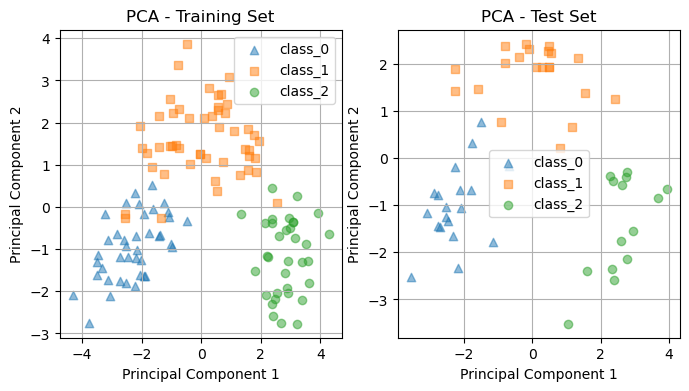

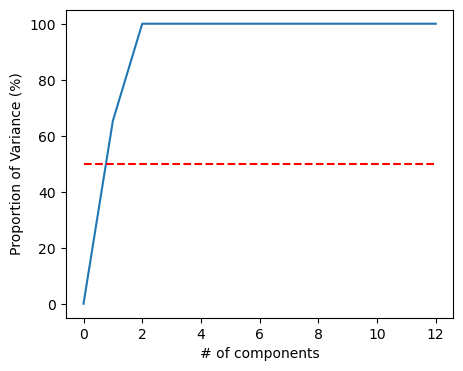

In [5]:
# Apply PCA to the Iris dataset (reducing to 2 dimensions)
M = 2
Z, eigvecs, eigvals, mu = pca_classic(X_scaled, M)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y_wine, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predict for both training and testing sets
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calculate accuracy for both training and testing sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Training set classification accuracy: {accuracy_train:.2f}")
print(f"Testing set classification accuracy: {accuracy_test:.2f}")

# Generate and print the classification report for the testing set
print("\nClassification report for the testing set:")
print(classification_report(y_test, y_test_pred))

# Plotting the training set
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_pca(X_train, y_train, title="PCA - Training Set")

# Plotting the test set
plt.subplot(1, 2, 2)
plot_pca(X_test, y_test, title="PCA - Test Set")

plt.show()

# Plot the proportion of explained variance for components
x = range(X_wine.shape[1])
y = [np.sum(eigvals[:m].astype('float'))/np.sum(eigvals.astype('float'))*100 for m in x]

plt.figure(figsize=(5, 4))  
plt.plot(x, y)
plt.plot(x, [50]*len(x), 'r--')  
plt.ylabel("Proportion of Variance (%)")
plt.xlabel("# of components")
plt.show()


# Training and Testing using PCA from scikit-learn

Sklearn PCA Training set classification accuracy: 0.96
Sklearn PCA Testing set classification accuracy: 0.98

Classification report for the testing set:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



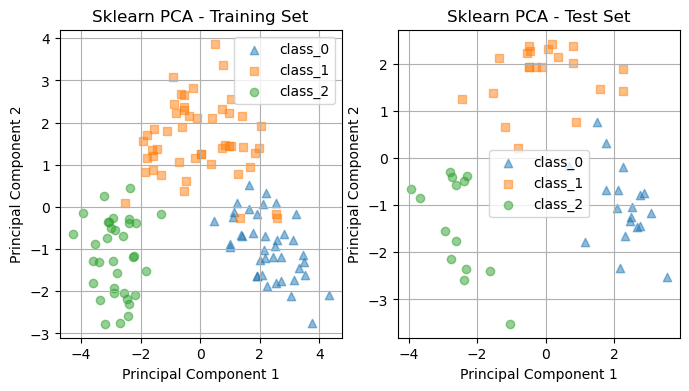

In [6]:
# Applying PCA from sklearn
pca_sklearn = PCA(n_components=M, svd_solver='full')
Z_sklearn = pca_sklearn.fit_transform(X_scaled)

# Split the dataset into training and testing sets
X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(Z_sklearn, y_wine, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier on sklearn PCA-transformed data
clf_sklearn = LogisticRegression(random_state=42)
clf_sklearn.fit(X_train_sklearn, y_train_sklearn)

# Predict for training and testing sets
y_train_pred_sklearn = clf_sklearn.predict(X_train_sklearn)
y_test_pred_sklearn = clf_sklearn.predict(X_test_sklearn)

# Calculate accuracy for training and testing sets
accuracy_train_sklearn = accuracy_score(y_train_sklearn, y_train_pred_sklearn)
accuracy_test_sklearn = accuracy_score(y_test_sklearn, y_test_pred_sklearn)

print(f"Sklearn PCA Training set classification accuracy: {accuracy_train_sklearn:.2f}")
print(f"Sklearn PCA Testing set classification accuracy: {accuracy_test_sklearn:.2f}")

# Generate and print the classification report for the testing set
print("\nClassification report for the testing set:")
print(classification_report(y_test_sklearn, y_test_pred_sklearn))

# Plotting the training set for sklearn PCA
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_pca(X_train_sklearn, y_train_sklearn, title="Sklearn PCA - Training Set")

# Plotting the test set for sklearn PCA
plt.subplot(1, 2, 2)
plot_pca(X_test_sklearn, y_test_sklearn, title="Sklearn PCA - Test Set")

plt.show()